In [1]:
import pickle
import json
import copy
import random
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import  Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim

from tqdm import tqdm_notebook

In [5]:
class SongDataset(Dataset):    

    def __init__(self, songs, max_song):
        
        self.songs = songs
        self.max_song = max_song
        self.vector = np.zeros(max_song, dtype=np.float32)
        
    def get_vector(self, vec):
        cop_vector = copy.deepcopy(self.vector)
        if vec:
            cop_vector[vec] = 1            
        return cop_vector    

        
    def denosing(self, x):
        if len(x)<2:
            return x
        tr, te = train_test_split(x, test_size=0.2)
        return tr
    
    def __getitem__(self, idx):
        
        x = self.songs[idx]        
        d_x = self.denosing(x)
        d_x = self.get_vector(d_x)
        x = self.get_vector(x)
        return d_x, x
        
    def __len__(self):
        return len(self.songs)


In [2]:
with open('./dataset/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
    max_song = len(meta['idx_song'])

with open('./dataset/train.json', encoding='UTF-8') as json_file:
    data = json.load(json_file)

In [3]:
songs = [x["songs"]  for x in data]

In [4]:
max_song

707989

In [5]:
# http://cs230.stanford.edu/files_winter_2018/projects/6937581.pdf
# https://openreview.net/pdf?id=SkNQeiRpb
# n, 128, 256, 256, dp(0.65), 256, 128, n

In [7]:
def mse_loss_with_nans(output, target):

    # Missing data are nan's
    # mask = torch.isnan(target)

    # Missing data are 0's
    mask = target == 0

    out = (output[~mask]-target[~mask])**2
    loss = out.mean()

    return torch.sqrt(loss)

In [8]:
dataset = SongDataset(songs, max_song)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
# n -> 128 -> 256 -> 256 -> || -> 256 -> 
class AE(nn.Module):
    def __init__(self, max_song):
        
        super(AE, self).__init__()        
        self.encoder = nn.Sequential(
                    nn.Linear(max_song, 128), 
                    nn.SELU(),
                    nn.Linear(128, 256),
                    nn.SELU(),
                    nn.Linear(256, 256),
                    nn.SELU()
        )
        self.dropout = nn.Dropout(p=0.7)
        self.decoder = nn.Sequential(
                    nn.Linear(256, 256),
                    nn.SELU(),                    
                    nn.Linear(256, 128),
                    nn.SELU(),                    
                    nn.Linear(128, max_song), 
                    nn.SELU()
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)        
        
        return x
model = AE(max_song)
criterion = mse_loss_with_nans
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [10]:
epochs = 10
model.train()
total_loss = list()
path = "model_{}.pth"
for epoch in range(epochs):
    train_acc = 0.0
    test_acc = 0.0
    
    running_loss = 0 
    for batch_id, (dx, x) in enumerate(tqdm_notebook(dataloader)): #model.train()
        optimizer.zero_grad()        
        output = model(dx)
        
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()         
        running_loss += loss.item()
        
        if batch_id % 30 == 0:
            print("epoch {} batch id {} run_loss {:.4f} loss {:.4f}".format(epoch+1, batch_id+1, running_loss/(batch_id+1),loss.item() ))
            
    total_loss.append(running_loss/(batch_id+1))
    print(total_loss)
    w_path = path.format(str(epoch))
    torch.save(model.state_dict(), w_path)


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 362490368 bytes. Buy new RAM!


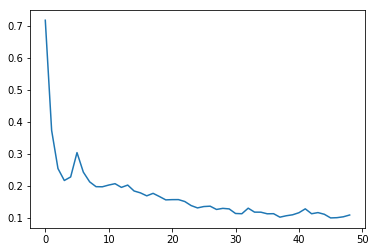

In [11]:
import matplotlib.pyplot as plt
#year과 pop은 미리 세팅됨
# Make a line plot: year on the x-axis, pop on the y-axis
plt.plot(total_loss)
plt.show()

In [12]:
output[0]

tensor([-0.1656,  0.1124,  0.0337,  ...,  0.8059,  0.3827, -0.0185],
       grad_fn=<SelectBackward>)

In [15]:
torch.sum(output[0]>0.5)

tensor(131270)

In [13]:
output[0][]

tensor([0.9891, 0.5362, 0.9547,  ..., 1.0000, 0.8872, 0.0445],
       grad_fn=<SelectBackward>)

In [13]:
a = np.arange(len(x[0]))[x[0]>0]
a
# y[0]

array([ 24409,  26083,  44603,  49047,  49921,  59003,  66214,  67697,
        87668,  95181, 109574, 116250, 116573, 118060, 119795, 121362,
       147466, 155233, 178124, 180708, 183949, 193610, 194117, 209120,
       216192, 219044, 231659, 241481, 246029, 253571, 258919, 285157,
       290769, 291080, 304964, 321321, 330238, 330553, 336933, 340679,
       342836, 348200, 355939, 356211, 362228, 372094, 373910, 375227,
       377785, 382542, 385234, 390770, 393654, 395416, 408870, 418519,
       438424, 440217, 442352, 465778, 472583, 485481, 491539, 504520,
       522825, 526161, 528599, 545007, 570171, 578240, 582137, 584775,
       586306, 590012, 600475, 604182, 606607, 608563, 610933, 617277,
       625650, 625875, 629738, 638130, 639531, 645489, 650764, 651499,
       656391, 657022, 669701, 670156, 674505, 686809, 700444, 701557,
       707564])

In [14]:
np.arange(len(dx[0]))[dx[0]>0]

array([ 26083,  44603,  66214,  87668,  95181, 116250, 116573, 119795,
       121362, 147466, 155233, 178124, 180708, 183949, 193610, 194117,
       216192, 219044, 231659, 241481, 246029, 253571, 258919, 290769,
       291080, 304964, 321321, 330238, 336933, 340679, 342836, 355939,
       356211, 362228, 373910, 382542, 385234, 390770, 393654, 395416,
       408870, 418519, 438424, 440217, 442352, 465778, 472583, 485481,
       491539, 522825, 526161, 528599, 545007, 570171, 578240, 582137,
       584775, 586306, 606607, 608563, 610933, 617277, 625650, 629738,
       638130, 639531, 645489, 651499, 656391, 657022, 669701, 670156,
       674505, 686809, 700444, 701557, 707564])

In [16]:
aa = np.arange(len(x[0]))[x[0]>0]
aa

array([ 24409,  26083,  44603,  49047,  49921,  59003,  66214,  67697,
        87668,  95181, 109574, 116250, 116573, 118060, 119795, 121362,
       147466, 155233, 178124, 180708, 183949, 193610, 194117, 209120,
       216192, 219044, 231659, 241481, 246029, 253571, 258919, 285157,
       290769, 291080, 304964, 321321, 330238, 330553, 336933, 340679,
       342836, 348200, 355939, 356211, 362228, 372094, 373910, 375227,
       377785, 382542, 385234, 390770, 393654, 395416, 408870, 418519,
       438424, 440217, 442352, 465778, 472583, 485481, 491539, 504520,
       522825, 526161, 528599, 545007, 570171, 578240, 582137, 584775,
       586306, 590012, 600475, 604182, 606607, 608563, 610933, 617277,
       625650, 625875, 629738, 638130, 639531, 645489, 650764, 651499,
       656391, 657022, 669701, 670156, 674505, 686809, 700444, 701557,
       707564])

In [17]:
output[0][aa]

tensor([0.9989, 0.9734, 0.9883, 1.0041, 0.9984, 0.9938, 0.9261, 1.0370, 1.0375,
        1.0848, 0.9601, 0.9917, 1.0259, 0.9806, 1.0084, 0.8422, 0.7190, 0.9086,
        1.0424, 0.7072, 1.0020, 1.0485, 1.0163, 0.9784, 0.9217, 0.7594, 1.0091,
        0.9789, 1.0274, 1.0168, 1.0186, 0.9595, 1.0157, 0.9761, 1.0449, 1.1034,
        0.9751, 0.9663, 0.9651, 0.9696, 0.9361, 1.0330, 1.0471, 1.0555, 0.9818,
        1.1405, 0.9849, 0.9537, 0.6701, 0.8301, 0.9741, 0.9297, 0.9484, 1.0126,
        0.9874, 0.9863, 0.9769, 0.9835, 0.9959, 1.0085, 1.0536, 0.9525, 0.9900,
        0.9912, 0.9709, 1.0245, 0.9543, 0.9528, 0.9482, 0.9554, 0.9042, 0.9140,
        1.0114, 0.9912, 0.9008, 1.0192, 0.9766, 0.9125, 1.0154, 0.9694, 1.0152,
        1.0227, 0.9649, 0.9949, 0.8577, 0.9965, 1.0723, 1.0934, 0.7656, 1.0328,
        0.9908, 0.7995, 1.0298, 0.9836, 0.7657, 1.0039, 0.9773],
       grad_fn=<IndexBackward>)

In [18]:
res = output[0].data.numpy().argsort()[-100:]
res

array([570637,  55884, 142955, 525178, 135288, 496515,  48367, 549597,
       413106, 525045, 705018, 591516, 145363, 139750, 476061, 200744,
         9036, 194767, 154333, 570914, 457770, 455217,  48220, 138834,
       650532, 691608, 209998, 488067,  89104, 603537, 110562, 415922,
       701093, 665795, 152148, 306736,  10162, 404908, 416916,  37261,
       287950, 571588,  43886,  38678, 281197, 515536, 587715, 124106,
       439364,  29505,   3039, 226893, 359950,  88887, 666927, 373700,
       460198, 291884, 571969, 569928, 421179,  48358, 268478, 673739,
       690288, 641471, 391928, 154772, 483083, 428538, 306195, 700393,
       382342, 420269, 511249, 585922, 545575, 603199, 416662, 509317,
       358088, 160810, 219017, 528997, 126804, 558227, 542497, 121040,
       411548, 202618, 112738, 196588,  44004, 460752, 100237, 681262,
       593593, 154362, 416801, 383586], dtype=int64)

In [21]:
output[0][aa]

tensor([0.7839, 0.9263, 0.6435, 0.8657, 0.9375, 1.1569, 0.9021, 1.0635, 0.7660,
        1.0110, 1.0078, 1.1363, 0.9434, 0.8942, 0.9051, 0.9163, 0.6797],
       grad_fn=<IndexBackward>)

In [22]:
output[0].data.numpy()[res]

array([1.3440679, 1.3441871, 1.3442128, 1.3443112, 1.3447115, 1.3449464,
       1.3449816, 1.3450669, 1.3459816, 1.3461945, 1.3463833, 1.3482533,
       1.3486217, 1.3487881, 1.3496361, 1.350858 , 1.3514051, 1.352024 ,
       1.353617 , 1.3536423, 1.3541024, 1.3550597, 1.3551944, 1.3552893,
       1.3565935, 1.3571932, 1.3573041, 1.3575879, 1.359416 , 1.359509 ,
       1.3595399, 1.3601441, 1.3603214, 1.3609442, 1.361938 , 1.3626397,
       1.3636484, 1.3637273, 1.3660142, 1.3662732, 1.3683466, 1.3698038,
       1.3703653, 1.371133 , 1.3713459, 1.3715507, 1.3716218, 1.3734533,
       1.3754936, 1.3755518, 1.3780223, 1.3797876, 1.3825054, 1.3831165,
       1.3833661, 1.3843997, 1.3845721, 1.3857245, 1.3880674, 1.3887419,
       1.3891057, 1.393857 , 1.3946155, 1.3947212, 1.3965513, 1.3979863,
       1.3992945, 1.3994298, 1.4001682, 1.4002291, 1.400767 , 1.4012548,
       1.4024173, 1.4029381, 1.4037236, 1.4039928, 1.4044383, 1.4045256,
       1.404688 , 1.4057602, 1.4063166, 1.4072641, 

In [26]:
len(output[0][output[0]==1])

111004

In [18]:
output[0][x[0]>0]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9586, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9308, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<IndexBackward>)

In [74]:
output

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)